# Project1: Car Price Prediction

This is my first project in Machine Learning with Scikit Learn. It is a supervised regression based problem. My goal is to predict the car price given different features. The dataset is downloaded from [Kaggle](https://www.kaggle.com/manoranjankrthakur/cardekho). I have used XGBoost Regressor with RandomizedSearchCV for prediction. I have achieved MAE = 0.22, MSE = 0.078 and RMSE = 0.2797 on the predicted dataset. The model is saved using pickle and deployed using Flask.

### Summary of the steps:

- Importing the important libraries
- Reading and Understanding the Dataset
- Preprocessing the Dataset
- Exploratory Data Analysis
- Preparing the data for model building
- Defining the model
- Hyperparameter tuning using RandomizedSearchCV
- Predicting the test dataset
- Evaluating the model
- Saving the model using Pickle



#### 1. Importing the important libraries

In [2]:
#!pip install pandas
#!pip install numpy
#!pip install matplotlib
#!pip install seaborn
#!pip install sklearn
#!pip install xgboost

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.filterwarnings("ignore", category=FutureWarning) 
warnings.filterwarnings("ignore", category=UserWarning) 

#### 2. Reading and Understanding the data

In [4]:
car = pd.read_csv("car data.csv")

In [5]:
car.head()

,Car_Name,Year,Selling_Price,Present_Price,Kms_Driven,Fuel_Type,Seller_Type,Transmission,Owner
0,ritz,2014,3.35,5.59,27000,Petrol,Dealer,Manual,0
1,sx4,2013,4.75,9.54,43000,Diesel,Dealer,Manual,0
2,ciaz,2017,7.25,9.85,6900,Petrol,Dealer,Manual,0
3,wagon r,2011,2.85,4.15,5200,Petrol,Dealer,Manual,0
4,swift,2014,4.60,6.87,42450,Diesel,Dealer,Manual,0


In [6]:
car.shape

(301, 9)

In [7]:
car.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 301 entries, 0 to 300
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Car_Name       301 non-null    object 
 1   Year           301 non-null    int64  
 2   Selling_Price  301 non-null    float64
 3   Present_Price  301 non-null    float64
 4   Kms_Driven     301 non-null    int64  
 5   Fuel_Type      301 non-null    object 
 6   Seller_Type    301 non-null    object 
 7   Transmission   301 non-null    object 
 8   Owner          301 non-null    int64  
dtypes: float64(2), int64(3), object(4)
memory usage: 21.3+ KB


In [8]:
car.describe()

,Year,Selling_Price,Present_Price,Kms_Driven,Owner
count,301.000000,301.000000,301.000000,301.000000,301.000000
mean,2013.627907,4.661296,7.628472,36947.205980,0.043189
std,2.891554,5.082812,8.644115,38886.883882,0.247915
min,2003.000000,0.100000,0.320000,500.000000,0.000000
25%,2012.000000,0.900000,1.200000,15000.000000,0.000000
50%,2014.000000,3.600000,6.400000,32000.000000,0.000000
75%,2016.000000,6.000000,9.900000,48767.000000,0.000000
max,2018.000000,35.000000,92.600000,500000.000000,3.000000


In [9]:
car.columns

Index(['Car_Name', 'Year', 'Selling_Price', 'Present_Price', 'Kms_Driven',
       'Fuel_Type', 'Seller_Type', 'Transmission', 'Owner'],
      dtype='object')

In [10]:
#Categorical Columns apart from Car_Name column
cat_cols  = ['Fuel_Type','Seller_Type','Transmission']
#Lets check how many unique values are present in each of them
for col in cat_cols:
    print(f"Unique Values in column {col}: ", car[col].unique())

Unique Values in column Fuel_Type:  ['Petrol' 'Diesel' 'CNG']
Unique Values in column Seller_Type:  ['Dealer' 'Individual']
Unique Values in column Transmission:  ['Manual' 'Automatic']


We have a total of 301 rows and 9 columns. Four columns are categorical while 5 columns posses numerical values. There are no missing values in the dataset.

#### 3. Data Cleaning and Preprocessing

We already know there are no missing values in the dataset. We will check for duplicates and outliers.

In [11]:
#We can confirm no missing values by this method too
car.isnull().sum()

Car_Name         0
Year             0
Selling_Price    0
Present_Price    0
Kms_Driven       0
Fuel_Type        0
Seller_Type      0
Transmission     0
Owner            0
dtype: int64

<AxesSubplot:>

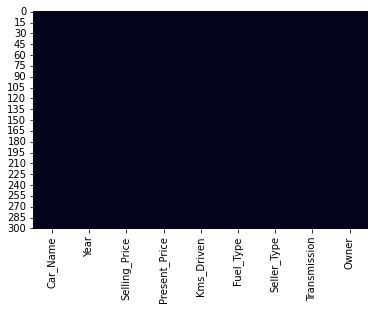

In [12]:
#Another way to check missing values in the dataset
sns.heatmap(car.isnull(), cbar = False)

If there were any missing data, we would have seen it in shape of a white bars on their respective column.

In [13]:
#dropping duplicates if any
car = car.drop_duplicates()
car.shape

(299, 9)

There were two duplicate rows which have been dropped from the dataframe.

##### Treating Outliers
The outliers can be identified and dealt with using 3 different methods.

- Univariate method
- Multivariate method
- Minkowski error
We will use the univariate method i-e box plot to identify and treat the outliers in the numerical columns.

Text(0.5, 1.0, 'Numerical Features Box Plot')

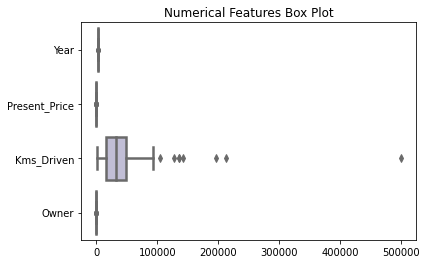

In [14]:
#first store the numerical features in a seperate dataframe.
num_cols  = [col for col in car.columns if car[col].dtype in ['int64', 'float64']]
## remove our target variable from the num_cols df
num_cols.remove("Selling_Price")
#Now plot a boxplot to identify the outliers in our numerical features.
sns.boxplot(data = car[num_cols], orient = 'h', palette = 'Set3', linewidth = 2.5 )
plt.title("Numerical Features Box Plot")


Kms_Driven column have outliers.

Text(0.5, 1.0, 'Target Column Box Plot')

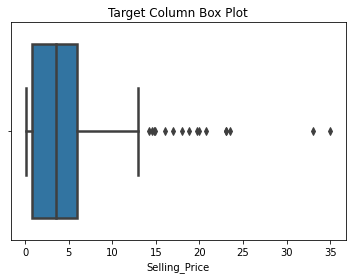

In [15]:
#checking the target varibale for outliers
sns.boxplot(x = car["Selling_Price"], orient = 'h', linewidth = 2.5 )
plt.title("Target Column Box Plot")

Our Target column also possess outliers. Let's find a way to treat outliers.

We will define our own function to identify and remove outliers. We will use the IQR (Inter Quartile Range) method to detect and remove outliers. The other method that we can use is the Z-score method.

from scipy import stats

df[(np.abs(stats.zscore(df)) < 3).all(axis=1)]

In [16]:
def removeoutliers(df=None, columns=None):
    for column in columns:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        floor, ceil = Q1 - 1.5 * IQR, Q3 + 1.5 * IQR
        df[column] = df[column].clip(floor, ceil)
        print(f"The columnn: {column}, has been treated for outliers.\n")
    return df
out_cols = ["Selling_Price","Kms_Driven"]
car_1 = removeoutliers(car,out_cols)

The columnn: Selling_Price, has been treated for outliers.

The columnn: Kms_Driven, has been treated for outliers.



##### Numerical and target column after treating outliers

Now we plot the numerical features and target column to see whether the outliers have been removed or not.

Text(0.5, 1.0, 'Numerical Features Box Plot after treating outliers')

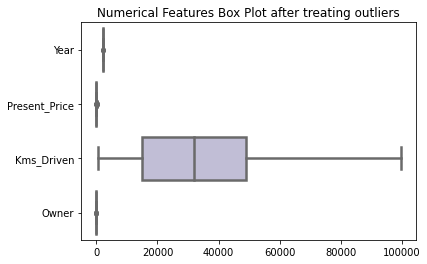

In [17]:
sns.boxplot(data = car_1[num_cols], orient = 'h', palette = 'Set3', linewidth = 2.5 )
plt.title("Numerical Features Box Plot after treating outliers")

Text(0.5, 1.0, 'Target Column Box Plot after treating outliers')

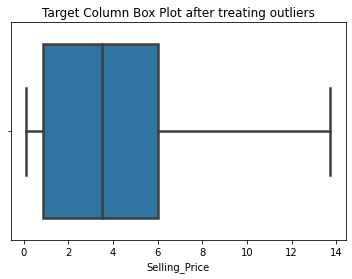

In [18]:
sns.boxplot(x = car_1["Selling_Price"], orient = 'h', linewidth = 2.5 )
plt.title("Target Column Box Plot after treating outliers")

Data Cleaning is done here!!!

Cool! Now since we have dealt with the missing values, duplicate data, and outliers, finally we can move on to exploratory data analysis, model building and preparing piepline.

#### 4. Exploratory Data Analysis

Here we will analyze the data, get insights, and identify the patterns in data.

To predict the selling price, its important that we know how old the car is. For that we will add another column by subtracting Year column from present year i-e 2022.

In [19]:
car_1["Total_Years"] = 2022 - car_1.Year
car_1.head()

,Car_Name,Year,Selling_Price,Present_Price,Kms_Driven,Fuel_Type,Seller_Type,Transmission,Owner,Total_Years
0,ritz,2014,3.35,5.59,27000.0,Petrol,Dealer,Manual,0,8
1,sx4,2013,4.75,9.54,43000.0,Diesel,Dealer,Manual,0,9
2,ciaz,2017,7.25,9.85,6900.0,Petrol,Dealer,Manual,0,5
3,wagon r,2011,2.85,4.15,5200.0,Petrol,Dealer,Manual,0,11
4,swift,2014,4.60,6.87,42450.0,Diesel,Dealer,Manual,0,8


##### Distribution of columns in the dataset

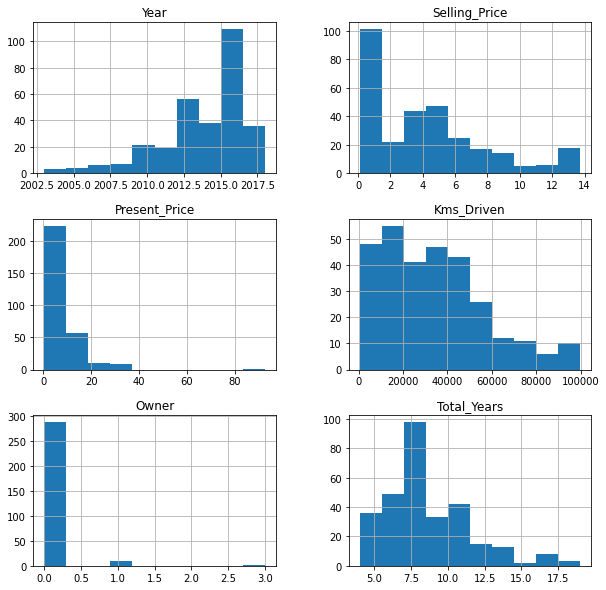

In [20]:
car_1.hist(bins = 10, figsize = (10,10))
plt.show()

The columns distribution is highly skewed.

##### Checking the Correlation of columns with each other¶
Now we will find the correlation of our features with each other and with the target column using the seaborn heatmap library.

<AxesSubplot:>

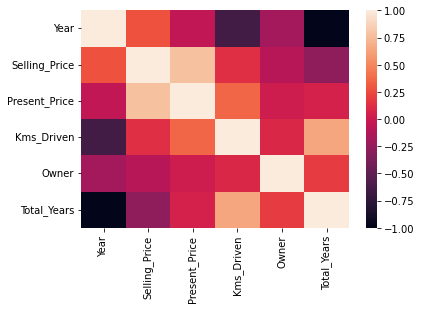

In [21]:
#plot the heatmap
sns.heatmap(car_1.corr())

Our selling price is positively correlated with the present price and negatively correlated with the total years. This means the selling price will be high if the present price is high and total years are less.

#### 5. Preparing the Data for model building

In [22]:
#removing the target column from the dataframe
y = car_1.loc[:,'Selling_Price']
X = car_1.drop(['Selling_Price','Car_Name','Year'],axis=1)
print(X.shape, y.shape)

(299, 7) (299,)


In [23]:
X.head()

,Present_Price,Kms_Driven,Fuel_Type,Seller_Type,Transmission,Owner,Total_Years
0,5.59,27000.0,Petrol,Dealer,Manual,0,8
1,9.54,43000.0,Diesel,Dealer,Manual,0,9
2,9.85,6900.0,Petrol,Dealer,Manual,0,5
3,4.15,5200.0,Petrol,Dealer,Manual,0,11
4,6.87,42450.0,Diesel,Dealer,Manual,0,8


##### One hot Encoding

We will convert categorical features into numerical features by one hot encoding.

In [24]:
X = pd.get_dummies(X, drop_first = True)
X.head()

,Present_Price,Kms_Driven,Owner,Total_Years,Fuel_Type_Diesel,Fuel_Type_Petrol,Seller_Type_Individual,Transmission_Manual
0,5.59,27000.0,0,8,0,1,0,1
1,9.54,43000.0,0,9,1,0,0,1
2,9.85,6900.0,0,5,0,1,0,1
3,4.15,5200.0,0,11,0,1,0,1
4,6.87,42450.0,0,8,1,0,0,1


In [25]:
X.describe()

,Present_Price,Kms_Driven,Owner,Total_Years,Fuel_Type_Diesel,Fuel_Type_Petrol,Seller_Type_Individual,Transmission_Manual
count,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000
mean,7.541037,34387.096990,0.043478,8.384615,0.193980,0.799331,0.354515,0.869565
std,8.567887,23819.913773,0.248720,2.896868,0.396076,0.401172,0.479168,0.337346
min,0.320000,500.000000,0.000000,4.000000,0.000000,0.000000,0.000000,0.000000
25%,1.200000,15000.000000,0.000000,6.000000,0.000000,1.000000,0.000000,1.000000
50%,6.100000,32000.000000,0.000000,8.000000,0.000000,1.000000,0.000000,1.000000
75%,9.840000,48883.500000,0.000000,10.000000,0.000000,1.000000,1.000000,1.000000
max,92.600000,99708.750000,3.000000,19.000000,1.000000,1.000000,1.000000,1.000000


##### Feature Importance

In [26]:
from sklearn.ensemble import ExtraTreesRegressor
regressor = ExtraTreesRegressor()
regressor.fit(X,y)

ExtraTreesRegressor()

In [27]:
print(regressor.feature_importances_)

[0.29611405 0.0345294  0.00063292 0.09792197 0.08160492 0.03112359
 0.40661054 0.05146261]


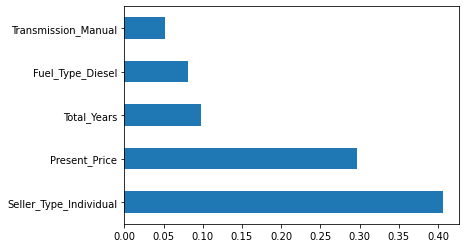

In [28]:
#plotting graph for better visualizations
feat_importance = pd.Series(regressor.feature_importances_,index=X.columns)
feat_importance.nlargest(5).plot(kind='barh')
plt.show()

In [29]:
# Split the data into train test set
from sklearn.model_selection import train_test_split
X_train, X_test,y_train, y_test = train_test_split(X,y,train_size = 0.9, test_size = 0.1)
print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)

(269, 8) (30, 8) (269,) (30,)


#### 6. Defining the Model

In [30]:
from xgboost import XGBRegressor
model = XGBRegressor()

#### 7. Hyperparameter Tuning using RandomizedSearchCV

In [31]:
 #Randomized Search CV
from sklearn.model_selection import RandomizedSearchCV
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1200, num = 12)]
learning_rate = [0.05,0.1,0.3,0.5]
max_depth = [int(x) for x in np.linspace(5, 30, num = 6)]



In [32]:
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'learning_rate': learning_rate,
               'max_depth': max_depth}

print(random_grid)

{'n_estimators': [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200], 'learning_rate': [0.05, 0.1, 0.3, 0.5], 'max_depth': [5, 10, 15, 20, 25, 30]}


#### 8. Building the Model

In [33]:
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations
xg_random = RandomizedSearchCV(estimator = model, param_distributions = random_grid,scoring='neg_mean_squared_error', n_iter = 10, cv = 5, verbose=2, random_state=42, n_jobs = 1)


In [34]:
xg_random.fit(X_train,y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END learning_rate=0.05, max_depth=20, n_estimators=1000; total time=   1.1s
[CV] END learning_rate=0.05, max_depth=20, n_estimators=1000; total time=   1.1s
[CV] END learning_rate=0.05, max_depth=20, n_estimators=1000; total time=   1.1s
[CV] END learning_rate=0.05, max_depth=20, n_estimators=1000; total time=   1.2s
[CV] END learning_rate=0.05, max_depth=20, n_estimators=1000; total time=   1.2s
[CV] END ..learning_rate=0.3, max_depth=10, n_estimators=200; total time=   0.2s
[CV] END ..learning_rate=0.3, max_depth=10, n_estimators=200; total time=   0.1s
[CV] END ..learning_rate=0.3, max_depth=10, n_estimators=200; total time=   0.2s
[CV] END ..learning_rate=0.3, max_depth=10, n_estimators=200; total time=   0.2s
[CV] END ..learning_rate=0.3, max_depth=10, n_estimators=200; total time=   0.2s
[CV] END ..learning_rate=0.5, max_depth=20, n_estimators=500; total time=   0.3s
[CV] END ..learning_rate=0.5, max_depth=20, n_es

RandomizedSearchCV(cv=5,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None,
                                          enable_categorical=False, gamma=None,
                                          gpu_id=None, importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=None,
                                          max_delta_step=None, max_depth=None,
                                          min_child_weight=None, missing=nan,
                                          monotone_constraints=...
                                          reg_alpha=None, reg_lambda=None,
                                          scale_pos_weight=None, subsample=None,
                                   

In [35]:
xg_random.best_params_

{'n_estimators': 1000, 'max_depth': 20, 'learning_rate': 0.05}

In [36]:
xg_random.best_score_

-1.074268755593573

#### 9. Predicting the Test Dataset

In [37]:
predictions=xg_random.predict(X_test)

<AxesSubplot:xlabel='Selling_Price', ylabel='Density'>

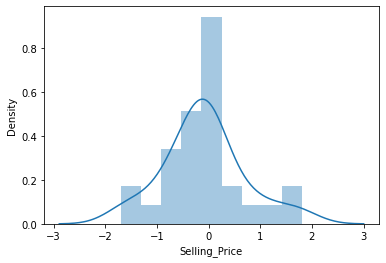

In [38]:
sns.distplot(y_test-predictions)

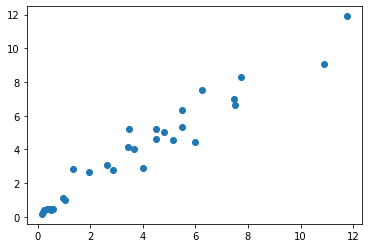

In [39]:
plt.scatter(y_test,predictions)

Linear and uniform distribution of predicted dataset shows how excellent our model is performing. Let's use some common evaluation metric to prove it.

#### 9. Evaluating the Model 

In [40]:
from sklearn import metrics
print('MAE:', metrics.mean_absolute_error(y_test, predictions))
print('MSE:', metrics.mean_squared_error(y_test, predictions))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, predictions)))

MAE: 0.5604080678621929
MSE: 0.6040447543159294
RMSE: 0.7772031615452484


#### 10. Saving the Model using Pickle

In [44]:
import pickle
# open a file, where you ant to store the data
filename = 'XGBoost.pkl'
pickle.dump(xg_random, open(filename, 'wb'))

-0.6040447543159294
